# Handling Imbalanced Datasets for Churn Prediction 📞

A common challenge in classification problems is dealing with an **imbalanced dataset**, where one class is represented far more often than the other. A classic example is customer churn prediction, where the number of customers who *do not* churn is typically much larger than the number of customers who *do*.

### The Problem with Accuracy

When a dataset is imbalanced, **accuracy** can be a very misleading metric. A model can achieve high accuracy by simply always predicting the majority class. For example, if 95% of customers don't churn, a model that always predicts "no churn" will be 95% accurate, but it will be completely useless for the business goal of identifying customers who are likely to leave.

The real goal is to improve the model's ability to predict the **minority class** (in this case, `Churn = 1`). We will focus on improving the **recall** for this class, which measures the model's ability to "catch" all the actual churners.

This notebook demonstrates three common resampling techniques from the `imbalanced-learn` library to address this problem.

---


## 1. The Imbalanced Churn Dataset

First, let's load our customer churn dataset and visualize the class distribution.


In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("churn.csv")
df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


<Axes: xlabel='Churn'>

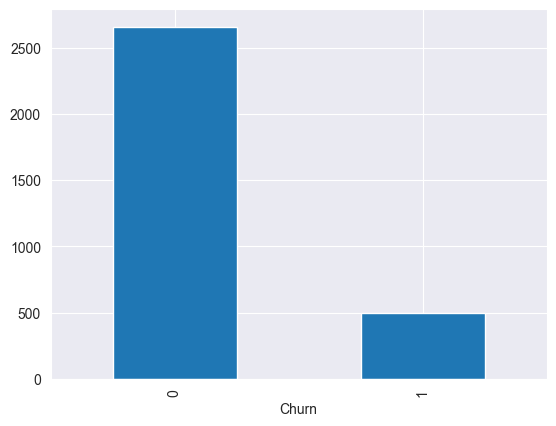

In [3]:
df.Churn.value_counts().plot(kind='bar')

The bar chart clearly shows the class imbalance: there are far more instances of `0` (no churn) than `1` (churn).


In [5]:
X = df.drop('Churn', axis="columns")
y = df['Churn']

## 2. Baseline Model Performance

Let's train a standard `LogisticRegression` model on this original, imbalanced data to establish a baseline. We use `stratify=y` in our train-test split to ensure the same class proportion exists in both the training and test sets.


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = df.drop('Churn', axis="columns")
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       531
           1       0.78      0.40      0.53        99

    accuracy                           0.89       630
   macro avg       0.84      0.69      0.74       630
weighted avg       0.88      0.89      0.87       630



**Interpretation:** The model has a high accuracy of **89%**, but look at the **recall for class 1 (churn): it's only 0.40!** This means our baseline model is failing to identify 60% of the customers who are actually going to churn, making it ineffective for its intended purpose.


## 3. Techniques for Handling Class Imbalance

To fix this, we will use **resampling techniques** to create a balanced training dataset. **Important:** These techniques should *only* be applied to the training data, never the test data.

### a) Random Undersampling

This technique balances the data by randomly removing samples from the majority class.
* **Pro:** It's fast and simple.
* **Con:** It can discard potentially useful information from the majority class.


In [14]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print(y_train_rus.value_counts())

model_rus = LogisticRegression(max_iter=10000)
model_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = model_rus.predict(X_test)
print(classification_report(y_test, y_pred_rus))

Churn
0    396
1    396
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.97      0.81      0.88       531
           1       0.46      0.85      0.60        99

    accuracy                           0.82       630
   macro avg       0.71      0.83      0.74       630
weighted avg       0.89      0.82      0.84       630



### b) SMOTE (Synthetic Minority Over-sampling Technique)

This technique balances the data by creating new, *synthetic* samples for the minority class. It looks at the feature space for minority samples and generates new examples that lie between them.
* **Pro:** No information is lost from the majority class.
* **Con:** Can introduce noise by creating synthetic samples in areas where the classes overlap.


In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(y_train_smote.value_counts())

model_smote = LogisticRegression(max_iter=10000)
model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = model_smote.predict(X_test)
print(classification_report(y_test, y_pred_smote))

Churn
0    2124
1    2124
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       531
           1       0.45      0.86      0.59        99

    accuracy                           0.81       630
   macro avg       0.71      0.83      0.73       630
weighted avg       0.89      0.81      0.83       630



**Result:** SMOTE produces a similar outcome to undersampling, with **recall for churn increasing to 0.86**.


### c) SMOTETomek (Hybrid Approach)

This is a hybrid method that combines over-sampling with under-sampling. It first uses SMOTE to increase the number of minority samples and then uses Tomek Links to remove samples from the majority class that are close to the minority class samples, which helps to clean the boundary between the classes.


In [16]:
from imblearn.combine import SMOTETomek

tomek = SMOTETomek(random_state=42)
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train, y_train)

print(y_train_tomek.value_counts())

model_tomek = LogisticRegression(max_iter=10000)
model_tomek.fit(X_train_tomek, y_train_tomek)
y_pred_tomek = model_tomek.predict(X_test)
print(classification_report(y_test, y_pred_tomek))

Churn
0    2091
1    2091
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       531
           1       0.45      0.86      0.59        99

    accuracy                           0.81       630
   macro avg       0.71      0.83      0.73       630
weighted avg       0.89      0.81      0.83       630



**Result:** The hybrid approach yields nearly identical results to SMOTE alone in this case.


## 4. Conclusion and Trade-offs

| Model | Overall Accuracy | Recall for Churn (Class 1) |
|:--- |:--- |:--- |
| **Baseline (Imbalanced)** | 89% | 40% |
| **Random Undersampling** | 82% | 85% |
| **SMOTE (Oversampling)** | 81% | 86% |

This comparison clearly shows the trade-off. By applying resampling techniques, we created models that are far superior at the actual business task (identifying churners), even though their overall accuracy is lower. For a problem like churn prediction, a model with high recall is often preferred, because the cost of failing to identify a churner (a false negative) is much higher than the cost of incorrectly flagging a happy customer (a false positive).